# **Forecasting Job Automation Risk Using Machine Learning**
*DS201 Final Project Xinyuan Liang*

# ***1. Business Understanding***

Advances in artificial intelligence and automation are rapidly reshaping the global labor market. Some occupations face higher risk due to repetitive tasks or strong exposure to emerging technologies, while others remain more resilient because they require complex skills, judgment, or human interaction.

This project uses machine learning models to predict whether a job in 2030 is at High, Medium, or Low risk of automation. Using occupational features such as skills, industry technology growth, AI exposure, salary, education, and experience, we identify which factors most influence risk levels and which model best detects vulnerable occupations. The goal is to provide insights that support workforce planning, reskilling strategies, and future career decision-making.

# ***2. Data Understanding***

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# load dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "AI_Impact_on_Jobs_2030.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "khushikyad001/ai-impact-on-jobs-2030",
    file_path,
)

df.head()

/tmp/ipython-input-2627731732.py:7: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 296k/296k [00:00<00:00, 2.26MB/s]


,Job_Title,Average_Salary,Years_Experience,Education_Level,AI_Exposure_Index,Tech_Growth_Factor,Automation_Probability_2030,Risk_Category,Skill_1,Skill_2,Skill_3,Skill_4,Skill_5,Skill_6,Skill_7,Skill_8,Skill_9,Skill_10
0,Security Guard,45795,28,Master's,0.18,1.28,0.85,High,0.45,0.10,0.46,0.33,0.14,0.65,0.06,0.72,0.94,0.00
1,Research Scientist,133355,20,PhD,0.62,1.11,0.05,Low,0.02,0.52,0.40,0.05,0.97,0.23,0.09,0.62,0.38,0.98
2,Construction Worker,146216,2,High School,0.86,1.18,0.81,High,0.01,0.94,0.56,0.39,0.02,0.23,0.24,0.68,0.61,0.83
3,Software Engineer,136530,13,PhD,0.39,0.68,0.60,Medium,0.43,0.21,0.57,0.03,0.84,0.45,0.40,0.93,0.73,0.33
4,Financial Analyst,70397,22,High School,0.52,1.46,0.64,Medium,0.75,0.54,0.59,0.97,0.61,0.28,0.30,0.17,0.02,0.42


Attributes Simulation: Salary, experience, and education were sampled from realistic statistical distributions.

Automation Probability Modeling:
 - High-risk jobs -> 0.70-0.95 probability
 - Medium-risk jobs -> 0.30-0.70
 - Low-risk jobs -> 0.05-0.30

Categorization: Risk categories ("High", "Medium", "Low") derived from probability thresholds.

Skill Scores: Randomized (0-1) to represent ten skill dimensions like creativity, robotics, and communication.

### Basic Understanding of the Data

In [3]:
print("\nShape:", df.shape)


Shape: (3000, 18)


In [4]:
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Job_Title                    3000 non-null   object 
 1   Average_Salary               3000 non-null   int64  
 2   Years_Experience             3000 non-null   int64  
 3   Education_Level              3000 non-null   object 
 4   AI_Exposure_Index            3000 non-null   float64
 5   Tech_Growth_Factor           3000 non-null   float64
 6   Automation_Probability_2030  3000 non-null   float64
 7   Risk_Category                3000 non-null   object 
 8   Skill_1                      3000 non-null   float64
 9   Skill_2                      3000 non-null   float64
 10  Skill_3                      3000 non-null   float64
 11  Skill_4                      3000 non-null   float64
 12  Skill_5                      3000 non-null   float64
 13  Skill_6    

In [5]:
print("\nSummary statistics (numeric):")
display(df.describe())


Summary statistics (numeric):


,Average_Salary,Years_Experience,AI_Exposure_Index,Tech_Growth_Factor,Automation_Probability_2030,Skill_1,Skill_2,Skill_3,Skill_4,Skill_5,Skill_6,Skill_7,Skill_8,Skill_9,Skill_10
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,89372.279000,14.677667,0.501283,0.995343,0.501503,0.496973,0.497233,0.499313,0.503667,0.490270,0.499807,0.499160,0.502843,0.501433,0.493627
std,34608.088767,8.739788,0.284004,0.287669,0.247881,0.287888,0.288085,0.288354,0.287063,0.285818,0.286050,0.288044,0.289832,0.285818,0.286464
min,30030.000000,0.000000,0.000000,0.500000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58640.000000,7.000000,0.260000,0.740000,0.310000,0.240000,0.250000,0.250000,0.260000,0.240000,0.260000,0.250000,0.250000,0.260000,0.250000
50%,89318.000000,15.000000,0.500000,1.000000,0.500000,0.505000,0.500000,0.500000,0.510000,0.490000,0.500000,0.490000,0.500000,0.500000,0.490000
75%,119086.500000,22.000000,0.740000,1.240000,0.700000,0.740000,0.740000,0.750000,0.750000,0.730000,0.740000,0.750000,0.750000,0.740000,0.740000
max,149798.000000,29.000000,1.000000,1.500000,0.950000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# ***3. Data Preparation***

In [6]:
# duplicates rows
print("\nDuplicates rows:")
print(df.duplicated().sum())


Duplicates rows:
0


In [7]:
# missing values
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
Job_Title                      0
Average_Salary                 0
Years_Experience               0
Education_Level                0
AI_Exposure_Index              0
Tech_Growth_Factor             0
Automation_Probability_2030    0
Risk_Category                  0
Skill_1                        0
Skill_2                        0
Skill_3                        0
Skill_4                        0
Skill_5                        0
Skill_6                        0
Skill_7                        0
Skill_8                        0
Skill_9                        0
Skill_10                       0
dtype: int64


# ***4. Visualization***

### Numerical Columns

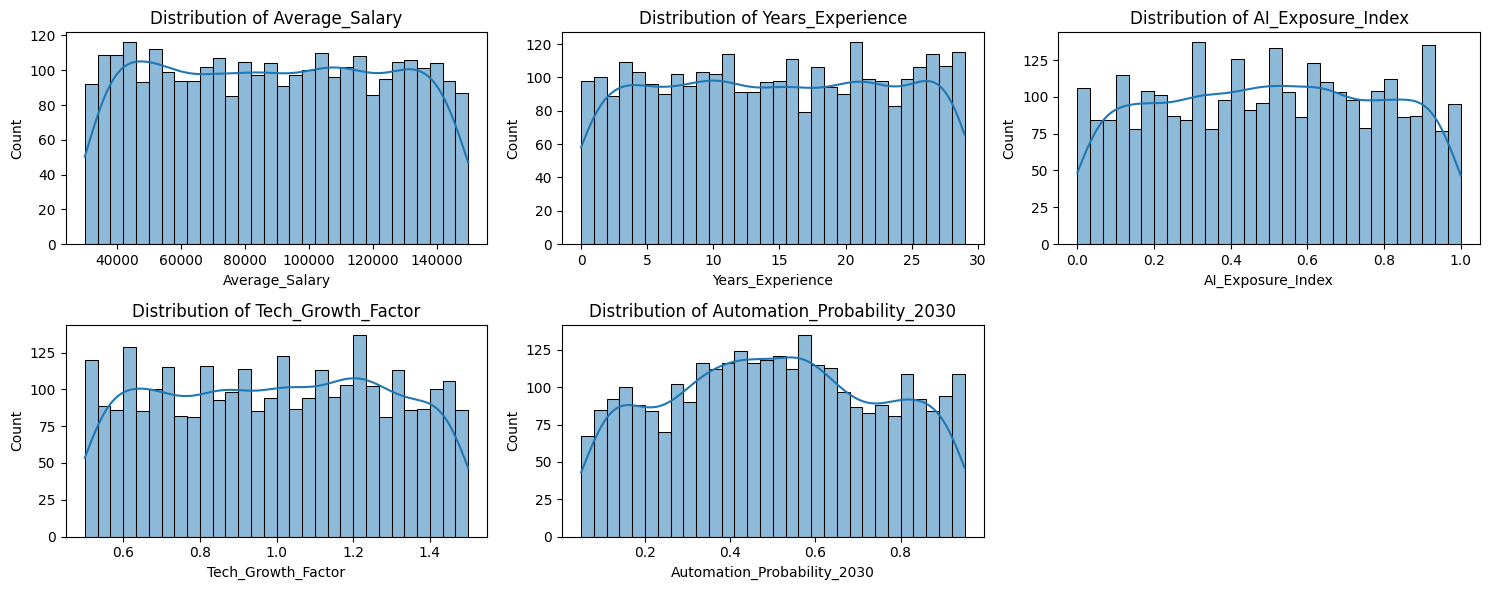

In [8]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

# remove skill columns from this list
skill_cols = [c for c in numeric_cols if c.startswith("Skill_")]
numeric_no_skill = [c for c in numeric_cols if c not in skill_cols]

fig, axes = plt.subplots(2, 3, figsize = (15, 6))
axes = axes.ravel()
for i, col in enumerate(numeric_no_skill):
    ax = axes[i]
    sns.histplot(
        df[col].dropna(),
        kde=True,
        bins=30,
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

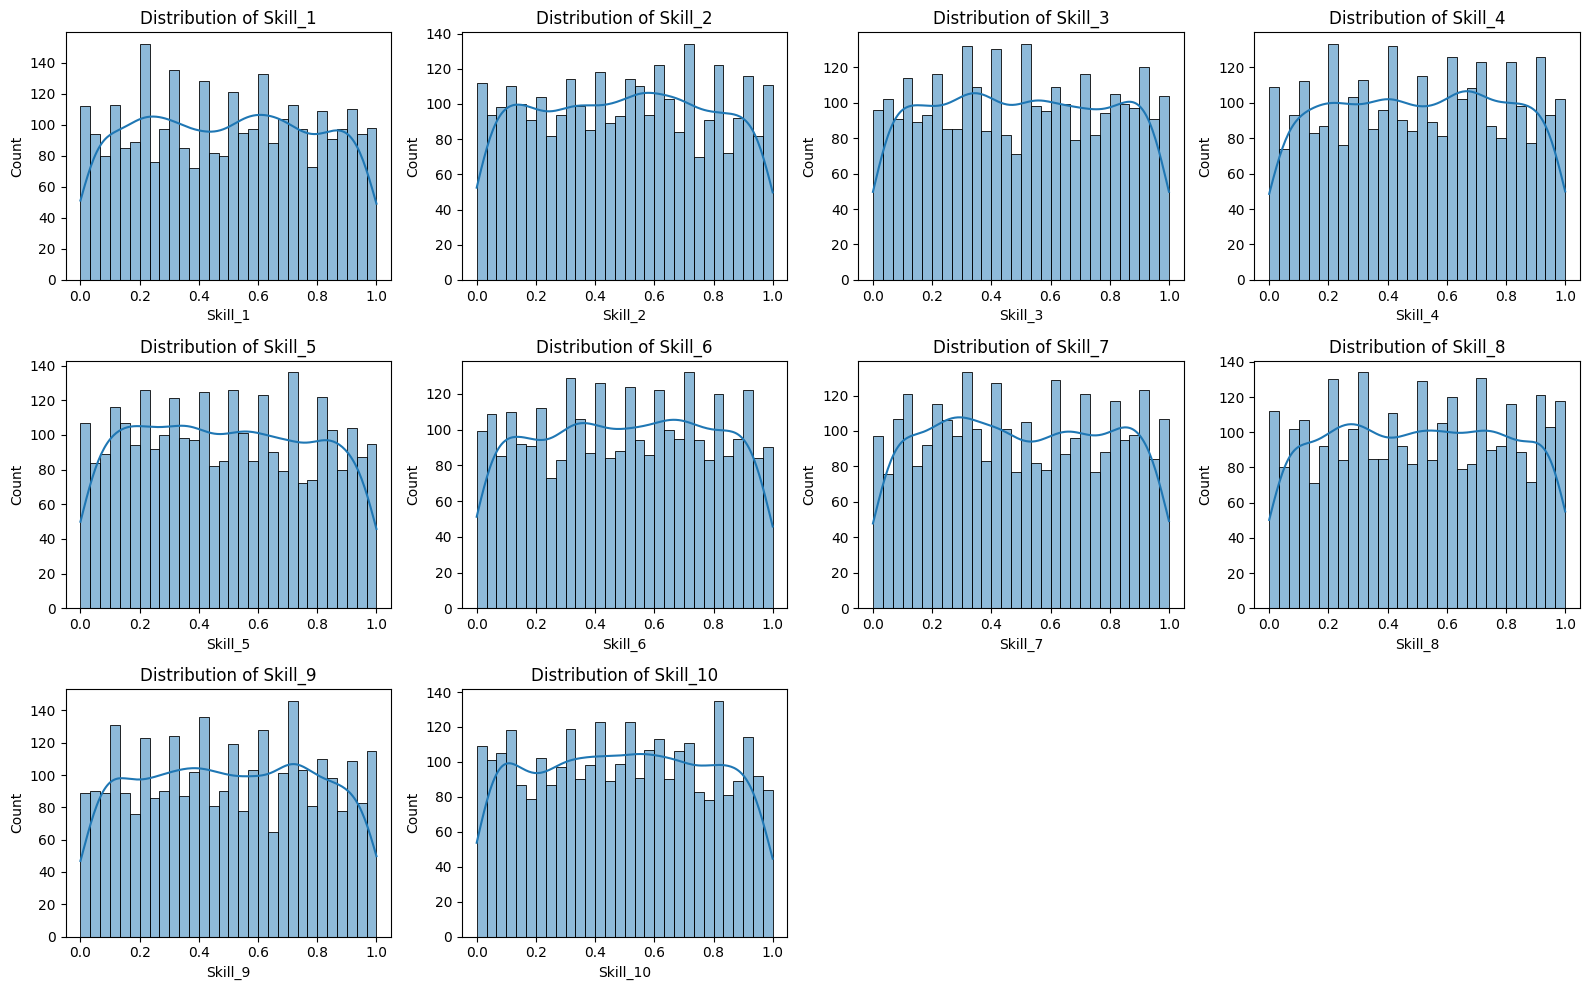

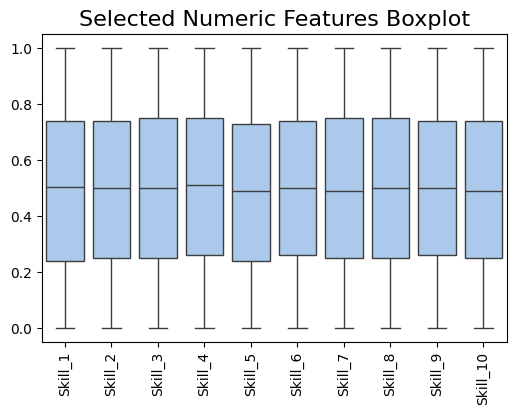

In [9]:
# barplot of TEN Skill Scores
fig, axes = plt.subplots(3, 4, figsize = (16,10))
axes = axes.ravel()

for i, col in enumerate(skill_cols):
    ax = axes[i]
    sns.histplot(df[col].dropna(), kde = True, bins = 30, ax = ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# boxplot of TEN Skill Scores
plt.figure(figsize = (6,4))
sns.boxplot(data = df[skill_cols], color = "#a1c9f4")
plt.title("Selected Numeric Features Boxplot", fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

### Categorical Columns

Education_Level
High School    784
Bachelor's     765
Master's       735
PhD            716
Name: count, dtype: int64


([0, 1, 2, 3],
 [Text(0, 0, "Master's"),
  Text(1, 0, 'PhD'),
  Text(2, 0, 'High School'),
  Text(3, 0, "Bachelor's")])

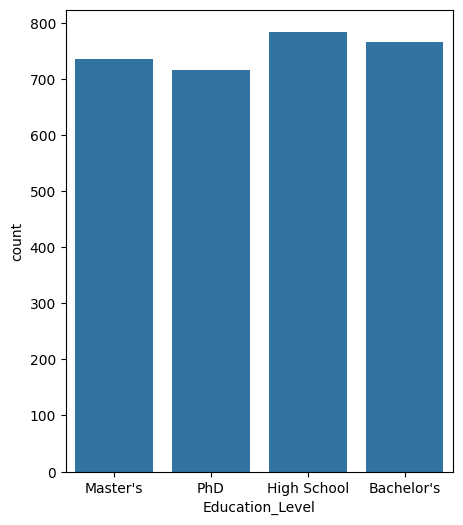

In [10]:
print(df['Education_Level'].value_counts())
plt.figure(figsize = (5,6))
sns.countplot(data = df, x = "Education_Level")
plt.xticks(rotation = 0)

Risk_Category
Medium    1521
High       740
Low        739
Name: count, dtype: int64


([0, 1, 2], [Text(0, 0, 'High'), Text(1, 0, 'Low'), Text(2, 0, 'Medium')])

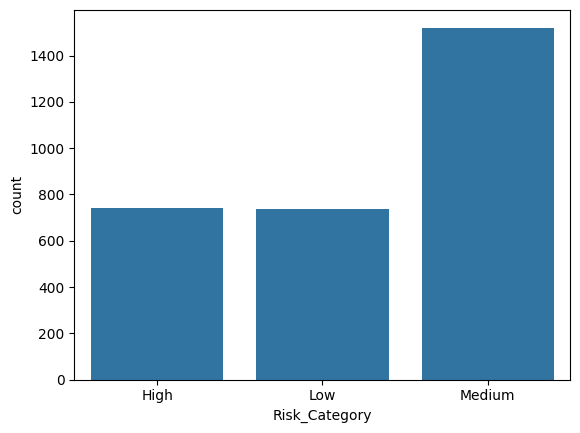

In [11]:
print(df["Risk_Category"].value_counts())

sns.countplot(data = df, x = "Risk_Category")
plt.xticks(rotation = 0)

### Correlation

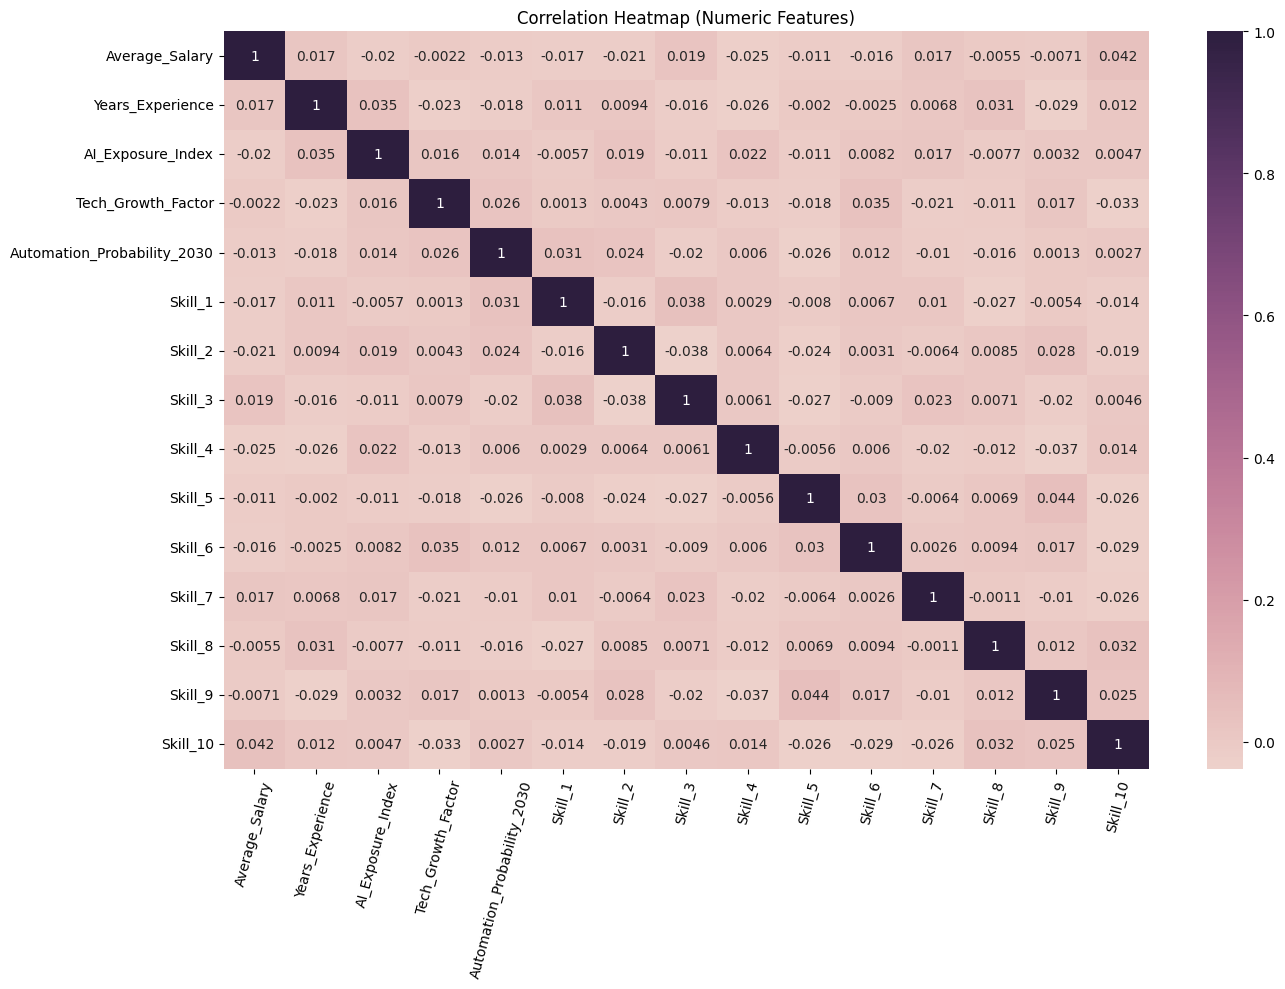

In [12]:
# ---- Correlation heatmap (numeric only) ----
numeric_cols = df.select_dtypes(include = ["int64", "float64"]).columns
plt.figure(figsize = (14, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot = True, cmap = sns.cubehelix_palette(as_cmap = True))
plt.title("Correlation Heatmap (Numeric Features)")
plt.xticks(rotation = 75)
plt.tight_layout()
plt.show()

SUMMARY
- Most skills (Skill_1 ... Skill_10) show no clear correlation with other variables.
- The data contains no outliers
- AI impact on most jobs is moderate -> most roles are not fully automatable but require monitoring technological changes.

# ***5. Prepared for the Models***


### Prepare features and target for Models


In [13]:
# numeric predictors (we **exclude** Automation_Probability_2030 because it is
# basically the underlying score that created Risk_Category)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols.remove("Automation_Probability_2030")

print("\nNumeric features used:")
print(numeric_cols)

# categorical predictor we want to KEEP
cat_cols = ["Education_Level"]

# build feature matrix and one-hot encode Education_Level
X = df[numeric_cols + cat_cols].copy()
X = pd.get_dummies(X, columns = cat_cols, drop_first = True)

y = df["Risk_Category"]


Numeric features used:
['Average_Salary', 'Years_Experience', 'AI_Exposure_Index', 'Tech_Growth_Factor', 'Skill_1', 'Skill_2', 'Skill_3', 'Skill_4', 'Skill_5', 'Skill_6', 'Skill_7', 'Skill_8', 'Skill_9', 'Skill_10']


## Spliting the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 123, stratify = y
)

print("\nTrain size:", X_train.shape, " Test size:", X_test.shape)


Train size: (2400, 17)  Test size: (600, 17)


# ***6. Models***

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(multi_class = 'multinomial')

lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# ---- Important Features — Logistic Regression ---
coefs = lr_clf.coef_[0]

importances = (
    pd.DataFrame({
        "Feature": X.columns,
        # use absolute value so positive and negative effects are both "strong"
        "Importance": np.abs(coefs)
    })
    .sort_values("Importance", ascending = False)
)

print("\nTop 15 important features by Logistic Regression:")
print(importances.head(15))


Top 15 important features by Logistic Regression:
                        Feature  Importance
9                       Skill_6    0.019978
3            Tech_Growth_Factor    0.017611
15     Education_Level_Master's    0.016576
16          Education_Level_PhD    0.015579
4                       Skill_1    0.015383
8                       Skill_5    0.014003
7                       Skill_4    0.013602
5                       Skill_2    0.012754
6                       Skill_3    0.012725
12                      Skill_9    0.011299
2             AI_Exposure_Index    0.009324
10                      Skill_7    0.003646
1              Years_Experience    0.002681
11                      Skill_8    0.001798
14  Education_Level_High School    0.001209



Logistic Regression Accuracy on test set: 0.507

Logistic Regression Classification report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       148
         Low       0.00      0.00      0.00       148
      Medium       0.51      1.00      0.67       304

    accuracy                           0.51       600
   macro avg       0.17      0.33      0.22       600
weighted avg       0.26      0.51      0.34       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


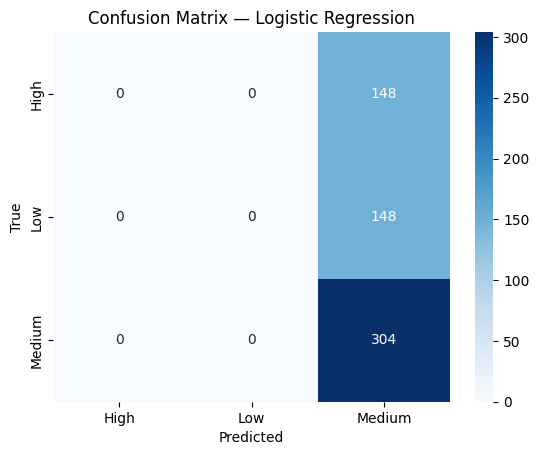

In [17]:
# ---- Accuracy — Logistic Regression ----
acc = accuracy_score(y_test, lr_pred)
print("\nLogistic Regression Accuracy on test set:", round(acc, 3))

# ---- Classification — Logistic Regression ----
print("\nLogistic Regression Classification report:")
print(classification_report(y_test, lr_pred))

# ---- Confusion Matrix — Logistic Regression ----
labels = np.sort(np.unique(np.concatenate([y_train, y_test])))
cm_lr = confusion_matrix(y_test, lr_pred, labels = labels)

sns.heatmap(pd.DataFrame(cm_lr, index = [labels], columns = [labels]),
            annot = True, fmt = 'd', cmap = 'Blues')
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

Logistic Regression
- Accuracy = 0.51

  About half of the test jobs are predicted correctly.

- Classification report
  - High: precision = 0, recall = 0 -> model never correctly predicts High.
  - Low: precision = 0, recall = 0 -> model never correctly predicts Low.
  - Medium: precision = 0.51, recall = 1.00 -> every job is predicted as Medium, and about half of them are truly Medium.

- Confusion matrix
  - All 600 test observations fall in the Medium predicted column. So the model is basically always saying "Medium risk" and ignoring High/Low.

## Decision Tree classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dt_clf = DecisionTreeClassifier(
    max_depth = 5,
    min_samples_split = 10,
    random_state = 123
)

dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

In [19]:
# ---- Important Features — Decision Tree ---
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": dt_clf.feature_importances_
    }).sort_values("Importance", ascending = False)

print("\nTop 15 important features by Decision Tree:")
print(importances.head(15))


Top 15 important features by Decision Tree:
                        Feature  Importance
12                      Skill_9    0.141029
6                       Skill_3    0.126207
7                       Skill_4    0.099853
8                       Skill_5    0.091148
10                      Skill_7    0.090164
4                       Skill_1    0.081847
0                Average_Salary    0.079320
9                       Skill_6    0.070137
1              Years_Experience    0.063720
13                     Skill_10    0.059183
5                       Skill_2    0.036119
3            Tech_Growth_Factor    0.033710
11                      Skill_8    0.027564
2             AI_Exposure_Index    0.000000
14  Education_Level_High School    0.000000



Decision Tree Accuracy on test set: 0.488

Decision Tree Classification report:
              precision    recall  f1-score   support

        High       0.30      0.11      0.17       148
         Low       0.00      0.00      0.00       148
      Medium       0.51      0.91      0.65       304

    accuracy                           0.49       600
   macro avg       0.27      0.34      0.27       600
weighted avg       0.33      0.49      0.37       600



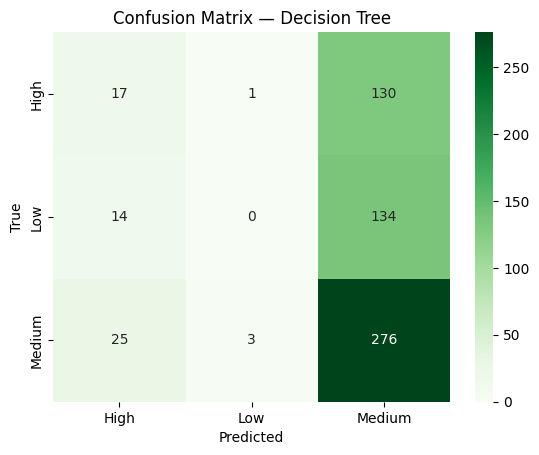

In [20]:
# ---- Accuracy — Decision Tree ----
acc = accuracy_score(y_test, y_pred)
print("\nDecision Tree Accuracy on test set:", round(acc, 3))

# ---- Classification — Decision Tree ----
print("\nDecision Tree Classification report:")
print(classification_report(y_test, y_pred))

# ---- Confusion Matrix — Decision Tree ----
cm = confusion_matrix(y_test, y_pred, labels = labels)

sns.heatmap(pd.DataFrame(cm, index = [labels], columns = [labels]),
            annot = True, fmt = 'd', cmap = 'Greens')
plt.title("Confusion Matrix — Decision Tree")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

Decision Tree
- Accuracy = 0.49
  
  Very similar to logistic regression, slightly lower.

- Classification report
  - High: precision = 0.30, recall = 0.11 -> a few High jobs are caught, but many are missed.
  - Low: precision = 0, recall = 0 -> Low jobs are still not detected.
  - Medium: precision = 0.51, recall = 0.91 -> most Medium jobs are correctly predicted.

- Confusion matrix
  - High and Low jobs are still mostly predicted as Medium,
  - but there are some correct High predictions, which is an improvement over logistic regression.

## Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators = 300,
    max_depth = None,
    min_samples_split = 5,
    min_samples_leaf = 2,
    random_state = 123,
    n_jobs = -1
)

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

In [22]:
# ---- Important Features — Random Forest ----
rf_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_clf.feature_importances_
    }).sort_values("Importance", ascending = False)

print("\nTop 15 important features by Random Forest:")
print(rf_importances.head(15))


Top 15 important features by Random Forest:
                     Feature  Importance
0             Average_Salary    0.078103
6                    Skill_3    0.072825
9                    Skill_6    0.071808
12                   Skill_9    0.071505
3         Tech_Growth_Factor    0.071382
4                    Skill_1    0.069597
2          AI_Exposure_Index    0.069089
11                   Skill_8    0.068932
5                    Skill_2    0.068802
7                    Skill_4    0.068468
8                    Skill_5    0.068045
10                   Skill_7    0.067749
13                  Skill_10    0.066784
1           Years_Experience    0.058601
15  Education_Level_Master's    0.009581



Random Forest Accuracy on test set: 0.503

Random Forest Classification report:
              precision    recall  f1-score   support

        High       0.17      0.01      0.01       148
         Low       0.50      0.01      0.01       148
      Medium       0.51      0.99      0.67       304

    accuracy                           0.50       600
   macro avg       0.39      0.33      0.23       600
weighted avg       0.42      0.50      0.35       600



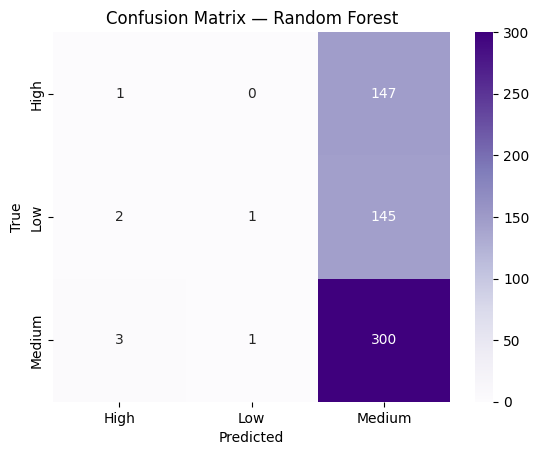

In [23]:
# ---- Accuracy — Random Forest ----
rf_acc = accuracy_score(y_test, rf_pred)
print("\nRandom Forest Accuracy on test set:", round(rf_acc, 3))

# ---- Classification — Random Forest ----
print("\nRandom Forest Classification report:")
print(classification_report(y_test, rf_pred))

# ---- Confusion Matrix — Random Forest ----
cm_rf = confusion_matrix(y_test, rf_pred, labels = labels)

sns.heatmap(pd.DataFrame(cm_rf, index = [labels], columns = [labels]),
            annot = True, fmt = 'd', cmap = 'Purples')
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

Random Forest
- Accuracy = 0.50
  About the same as logistic regression.

- Classification report
  - High: precision = 0.17, recall = 0.01 -> almost no High jobs are caught.
  - Low: precision = 0.50, recall = 0.01 -> almost no Low jobs are caught.
  - Medium: precision = 0.51, recall = 0.99 -> almost all jobs are predicted as Medium.

- Confusion matrix
  - Very similar to logistic regression: almost everything is predicted as Medium, with only a handful of High/Low predictions.

# ***Conclusion***

- Type I Error (False Positive)
  
  Predicted a job is High-risk when it is NOT High-risk. -> The model over-warns.

- Type II Error (False Negative)

  Predicted a job is NOT High-risk when it IS actually High-risk. -> The model misses the dangerous cases.

Type II error is worse here because:

Missing a truly High-risk job means you fail to warn someone who needs to prepare for automation risk.

Thus, we want to Minimize Type II error (higher recall for the High class)
  - Since Recall = TP / (TP + FN)
  - Low recall = many false negatives = high Type II error
  - High recall = fewer false negatives = low Type II error

Models
- Logistic Regression High recall = 0.00
- Decision Tree High recall = 0.11
- Random Forest High recall = 0.01

Decision Tree is the best model, because:

It has the highest recall for High-risk jobs. Therefore, it has the lowest Type II error. It is the only model that successfully identifies a meaningful number of High-risk jobs. Logistic Regression and Random Forest almost always predict Medium, so they completely fail to detect High-risk occupations.

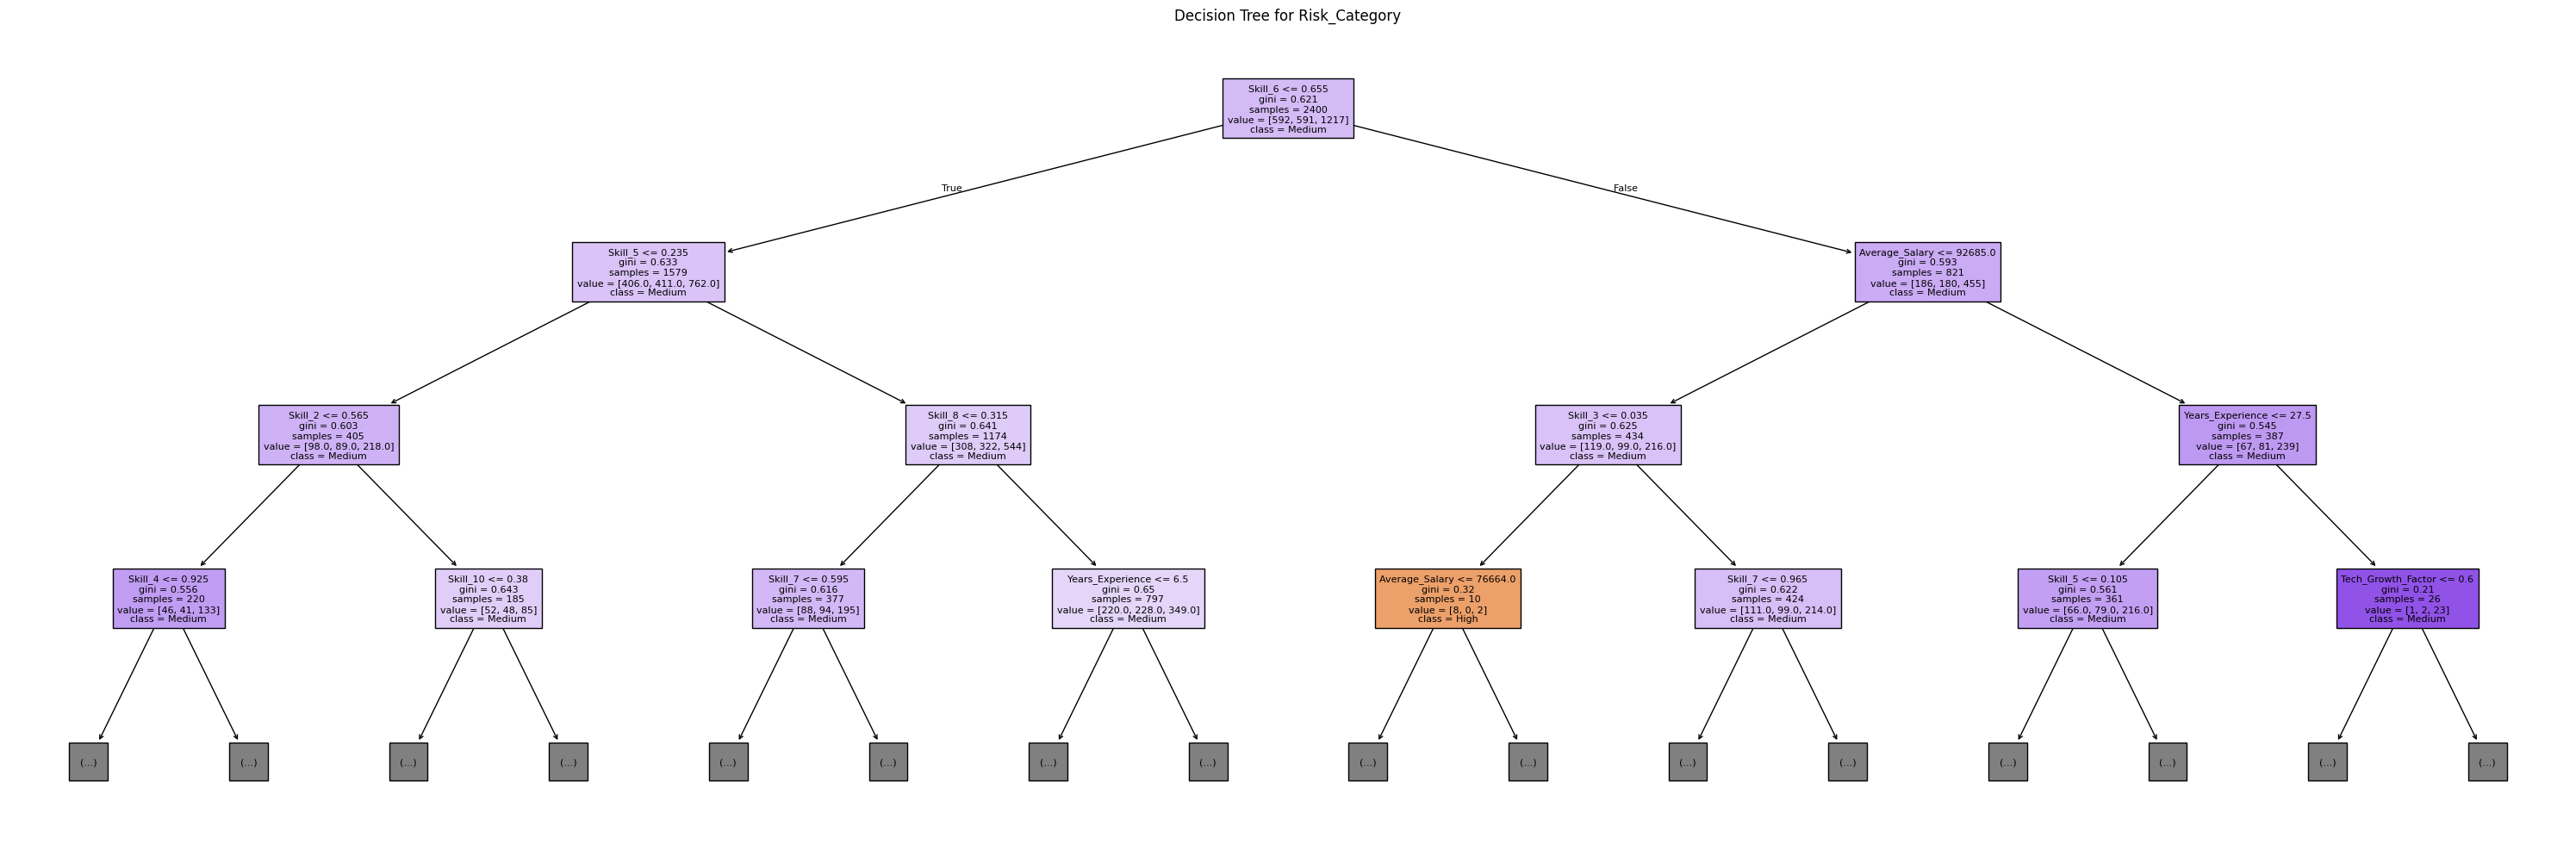

In [24]:
# ---- Visualize the Decision Tree ----
plt.figure(figsize = (30, 10))
plot_tree(
    dt_clf,
    feature_names = X.columns,
    class_names = sorted(y.unique()),
    filled = True,
    fontsize = 8,
    max_depth = 3
)
plt.title("Decision Tree for Risk_Category")
plt.tight_layout()
plt.show()

The Decision Tree shows that job skills are the primary drivers in predicting automation risk, with salary and experience playing secondary roles. Jobs that demand stronger, more specialized skill sets are less likely to be classified as high-risk. Meanwhile, jobs with weaker or more routine skill profiles fall into higher automation risk categories.